# Pre-Parcial - Taller en Python: Series de Tiempo, Joins, Visualización, Pivot Tables, y Storytelling (100 Puntos)

### CORRA LA SIGUIENTE LINEA SOLO UNA VEZ

In [1]:
!wget https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/europe_players.zip
!unzip europe_players.zip
!wget https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/Match.csv.zip
!unzip Match.csv.zip

--2024-10-18 13:46:46--  https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/europe_players.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/europe_players.zip [following]
--2024-10-18 13:46:47--  https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/europe_players.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4840920 (4.6M) [application/zip]
Saving to: ‘europe_players.zip’

europe_players.zip  100%[===================>]   4.62M  --.-KB/s    in 0.07s   

2024-10-18 13:46:47 (63.6 M

##Parte 1: Exploración Inicial de los Datos y Análisis de Medias (20 Puntos)


1.1 Cargar y Unir Tablas (10 Puntos)
Empezamos cargando las tablas y uniéndolas para facilitar el análisis. En esta etapa se enfoca en unir la tabla de partidos con la de equipos y atributos.

Base de Datos:
Las tablas disponibles son:

*   Country (11 filas, 2 columnas)
*   League (11 filas, 3 columnas)
*   Match (25,979 filas, 115 columnas)
*   Player (11,060 filas, 7 columnas)
*   Player_Attributes (183,978 filas, 42 columnas)
*   Team (299 filas, 5 columnas)
*   Team_Attributes (1,458 filas, 25 columnas)

In [2]:
import pandas as pd

matches = pd.read_csv('Match.csv')
teams = pd.read_csv('Team.csv')
team_attributes = pd.read_csv('Team_Attributes.csv')

matches_teams = pd.merge(matches, teams, left_on='home_team_api_id', right_on='team_api_id', how='left')
matches_teams = pd.merge(matches_teams, teams, left_on='away_team_api_id', right_on='team_api_id', how='left', suffixes=('_home', '_away'))

print(matches_teams.head())

   id_x  country_id  league_id     season  stage                 date  \
0     1           1          1  2008/2009      1  2008-08-17 00:00:00   
1     2           1          1  2008/2009      1  2008-08-16 00:00:00   
2     3           1          1  2008/2009      1  2008-08-16 00:00:00   
3     4           1          1  2008/2009      1  2008-08-17 00:00:00   
4     5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492473              9987              9993               1  ...   
1        492474             10000              9994               0  ...   
2        492475              9984              8635               0  ...   
3        492476              9991              9998               5  ...   
4        492477              7947              9985               1  ...   

   id_y  team_api_id_home  team_fifa_api_id_home  team_long_name_home  \
0     1              9987      

Pregunta de Negocio:

¿Cómo afecta la localía o el hecho de ser visitante en el rendimiento de los equipos? ¿Cuáles son los equipos que tienden a ganar más en casa o fuera de ella?

In [3]:
home_wins = matches_teams.groupby('team_long_name_home')['home_team_goal'].sum()
away_wins = matches_teams.groupby('team_long_name_away')['away_team_goal'].sum()

team_wins = pd.DataFrame({'home_wins': home_wins, 'away_wins': away_wins})

team_wins['win_diff'] = team_wins['home_wins'] - team_wins['away_wins']

team_wins = team_wins.sort_values('win_diff', ascending=False)

print("Equipos que tienden a ganar más en casa:")
print(team_wins.head(10))

print("\nEquipos que tienden a ganar más fuera:")
print(team_wins.sort_values('win_diff', ascending=True).head(10))

Equipos que tienden a ganar más en casa:
                     home_wins  away_wins  win_diff
Real Madrid CF             505        338       167
FC Barcelona               495        354       141
Manchester City            365        241       124
Atlético Madrid            321        203       118
Valencia CF                299        185       114
FC Bayern Munich           382        271       111
BSC Young Boys             319        210       109
Genoa                      249        143       106
Palermo                    225        126        99
Paris Saint-Germain        332        236        96

Equipos que tienden a ganar más fuera:
                      home_wins  away_wins  win_diff
SV Darmstadt 98              15         23        -8
SpVgg Greuther Fürth         10         16        -6
Waasland-Beveren             50         55        -5
Tondela                      15         19        -4
Crystal Palace               58         61        -3
SM Caen                     1

1.2 Análisis de Medias (10 Puntos)
Antes de realizar análisis complejos, obtenemos algunas estadísticas descriptivas que nos den una visión general de los datos. Calculemos las medias de goles en casa y fuera de casa.

In [4]:
average_home_goals = matches_teams['home_team_goal'].mean()
average_away_goals = matches_teams['away_team_goal'].mean()

print(f"Average home goals: {average_home_goals:.2f}")
print(f"Average away goals: {average_away_goals:.2f}")

Average home goals: 1.54
Average away goals: 1.16


Pregunta de Negocio:

¿Qué implicaciones tiene el hecho de que la media de goles locales sea mayor o menor que la de visitantes? ¿Cómo puede afectar esto las decisiones tácticas y estrategias de los equipos?

##Parte 2: Series de Tiempo y Tendencias Temporales (20 Puntos)


2.1 Análisis de Tendencias Temporales (10 Puntos)
Convertimos la columna de fechas en un formato de tiempo y analizamos la evolución de los goles anotados por temporada, tanto locales como visitantes. Esto ayudará a detectar si hay fluctuaciones en el rendimiento a lo largo del tiempo.

In [5]:
import pandas as pd

In [6]:
matches_teams['date'] = pd.to_datetime(matches_teams['date'])

matches_teams['season'] = matches_teams['date'].dt.year

season_goals = matches_teams.groupby('season').agg({'home_team_goal': 'sum', 'away_team_goal': 'sum'})

print("Evolution of goals scored by season:")
print(season_goals)

Evolution of goals scored by season:
        home_team_goal  away_team_goal
season                                
2008              2469            1768
2009              4982            3738
2010              5059            3646
2011              5054            3669
2012              5105            3977
2013              4887            3719
2014              4864            3708
2015              5116            3918
2016              2591            2017


Pregunta de Negocio:

¿Cómo varía el número de goles anotados en diferentes temporadas? ¿Existen picos o caídas significativas que puedan estar relacionadas con cambios en la estructura de la liga o en los equipos?

2.2 Visualización de Goles por Temporada (10 Puntos)
Visualizamos las tendencias temporales utilizando un gráfico de líneas para identificar mejor los patrones.

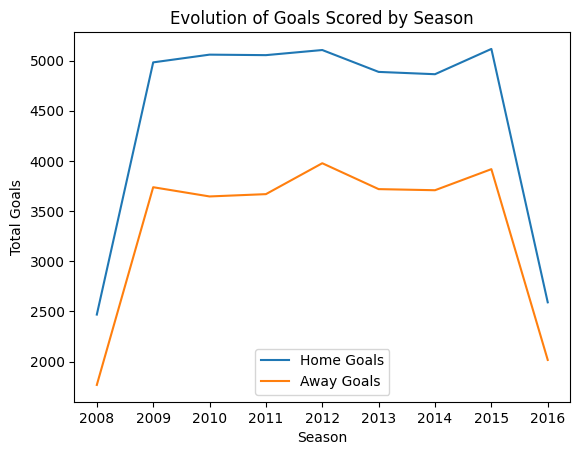

In [7]:
import matplotlib.pyplot as plt

plt.plot(season_goals.index, season_goals['home_team_goal'], label='Home Goals')
plt.plot(season_goals.index, season_goals['away_team_goal'], label='Away Goals')

plt.xlabel('Season')
plt.ylabel('Total Goals')
plt.title('Evolution of Goals Scored by Season')

plt.legend()

plt.show()

Pregunta de Negocio:

¿Cómo puede influir esta tendencia en las decisiones de los equipos para preparar una temporada? ¿Existen ciertos períodos del año donde deberían ajustar su estilo de juego?


##Parte 3: Análisis del Impacto de los Atributos del Equipo (20 Puntos)


3.1 Crosstab para Analizar la Relación entre Atributos y Goles (10 Puntos)
Usamos una tabla cruzada para ver si hay alguna correlación entre los atributos del equipo, como la velocidad del juego, y el número de goles anotados.

Datos del equipo:
  Velocidad del Juego  Goles Anotados
0                Alta               3
1                Alta               2
2               Media               0
3               Media               1
4                Baja               0
5                Baja               2
6                Alta               4
7               Media               3
8                Baja               1
9                Alta               5

Tabla Cruzada:
Goles Anotados       0 goles  1 gol  2 goles  3 goles  4 goles  5 goles
Velocidad del Juego                                                    
Alta                       0      0        1        1        1        1
Baja                       1      1        1        0        0        0
Media                      1      1        0        1        0        0

Correlación entre Velocidad del Juego y Goles Anotados: -0.602702332712179


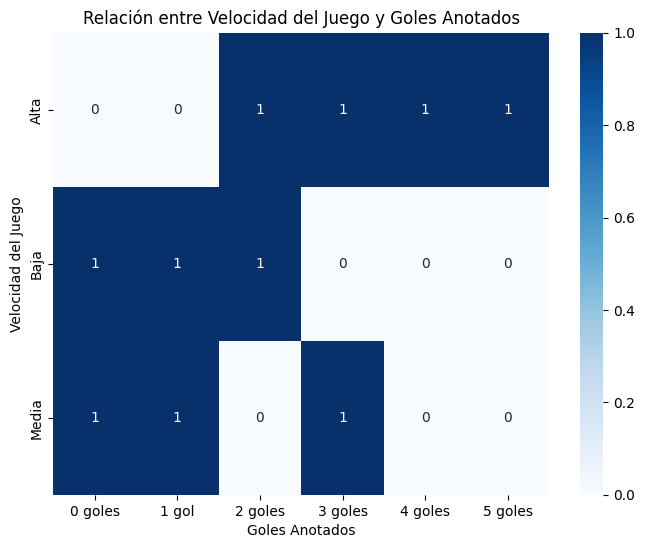

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = {
    'Velocidad del Juego': ['Alta', 'Alta', 'Media', 'Media', 'Baja', 'Baja', 'Alta', 'Media', 'Baja', 'Alta'],
    'Goles Anotados': [3, 2, 0, 1, 0, 2, 4, 3, 1, 5]
}

df = pd.DataFrame(data)

print("Datos del equipo:")
print(df)

tabla_cruzada = pd.crosstab(df['Velocidad del Juego'], pd.cut(df['Goles Anotados'], bins=[-1, 0, 1, 2, 3, 4, 5],
                                                              labels=['0 goles', '1 gol', '2 goles', '3 goles', '4 goles', '5 goles']))

print("\nTabla Cruzada:")
print(tabla_cruzada)

correlacion = df['Velocidad del Juego'].astype('category').cat.codes.corr(df['Goles Anotados'])
print("\nCorrelación entre Velocidad del Juego y Goles Anotados:", correlacion)

plt.figure(figsize=(8, 6))
sns.heatmap(tabla_cruzada, annot=True, cmap='Blues')
plt.title('Relación entre Velocidad del Juego y Goles Anotados')
plt.xlabel('Goles Anotados')
plt.ylabel('Velocidad del Juego')
plt.show()

Pregunta de Negocio:

¿Existe alguna relación clara entre la velocidad del juego de un equipo y el número de goles que anotan? ¿Cómo podrían usar los equipos esta información para ajustar sus estrategias?

3.2 Visualización de la Relación entre Velocidad y Goles (10 Puntos)
Creamos un gráfico de barras apiladas para representar cómo la velocidad del juego está relacionada con el número de goles anotados.

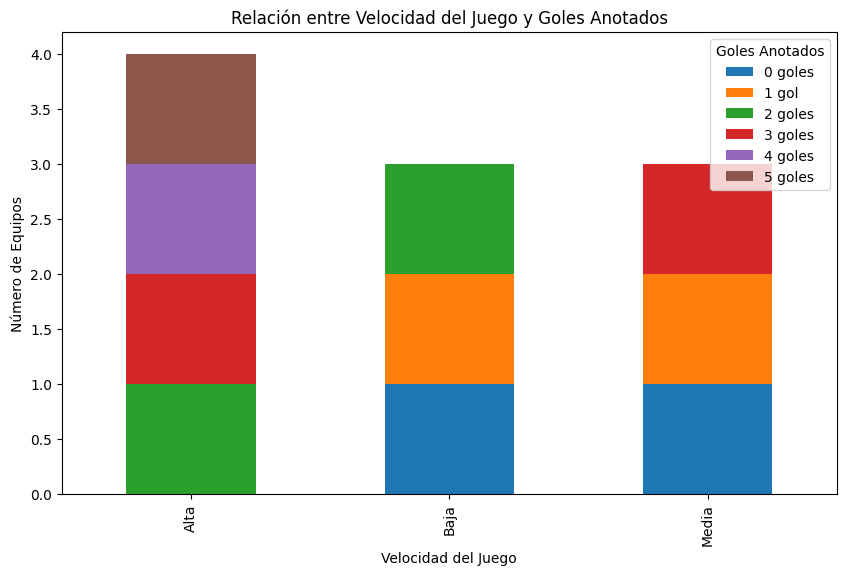

In [9]:
tabla_cruzada.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Relación entre Velocidad del Juego y Goles Anotados')
plt.xlabel('Velocidad del Juego')
plt.ylabel('Número de Equipos')
plt.legend(title='Goles Anotados')
plt.show()

Pregunta de Negocio:

¿Cómo puede esta información influir en las decisiones tácticas? Si los equipos que juegan a alta velocidad marcan más goles, ¿deberían todos los equipos intentar jugar más rápido?

##Parte 4: Uso de Pivot Tables para Análisis Comparativo (20 Puntos)


4.1 Pivot Table para Análisis de Goles por Temporada y Estilo de Juego (10 Puntos)
Creamos una pivot table para comparar cómo el estilo de juego de los equipos influye en el promedio de goles por temporada.

In [10]:
matches_teams_attributes = pd.merge(matches_teams, team_attributes[['team_api_id', 'buildUpPlaySpeed']], left_on='home_team_api_id', right_on='team_api_id', how='left')

pivot_table = pd.pivot_table(matches_teams_attributes, values=['home_team_goal', 'away_team_goal'], index='season', columns=['buildUpPlaySpeed'], aggfunc='mean')

print(pivot_table)

                 away_team_goal                                          \
buildUpPlaySpeed           20.0      23.0      24.0      25.0      26.0   
season                                                                    
2008                   1.583333       NaN  1.187500  0.971429  0.750000   
2009                   1.163636       NaN  0.864865  0.811594  1.100000   
2010                   0.644068  1.800000  0.702128  0.867647  1.611111   
2011                   1.120690  1.444444  0.785714  0.808219  0.965517   
2012                   1.200000       NaN  0.882353  1.194030  1.078947   
2013                   1.212766       NaN  1.065217  0.894737  0.944444   
2014                   0.907407       NaN  0.946429  1.029851  0.736842   
2015                   0.637931       NaN  0.881356  1.098592  1.025641   
2016                   1.281250       NaN  0.677419  0.941176  0.400000   

                                                                    ...  \
buildUpPlaySpeed      28

Pregunta de Negocio:

¿Qué estilos de juego han sido más efectivos a lo largo de las temporadas? ¿Los equipos deberían adaptar su estrategia en función del tipo de juego que otros equipos han utilizado con éxito en cada temporada?


4.2 Visualización Comparativa del Estilo de Juego (10 Puntos)
Visualizamos los resultados de la pivot table utilizando un gráfico de barras apiladas para comparar los promedios de goles por temporada y estilo de juego.

<ipython-input-11-3e4c164e0330>:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


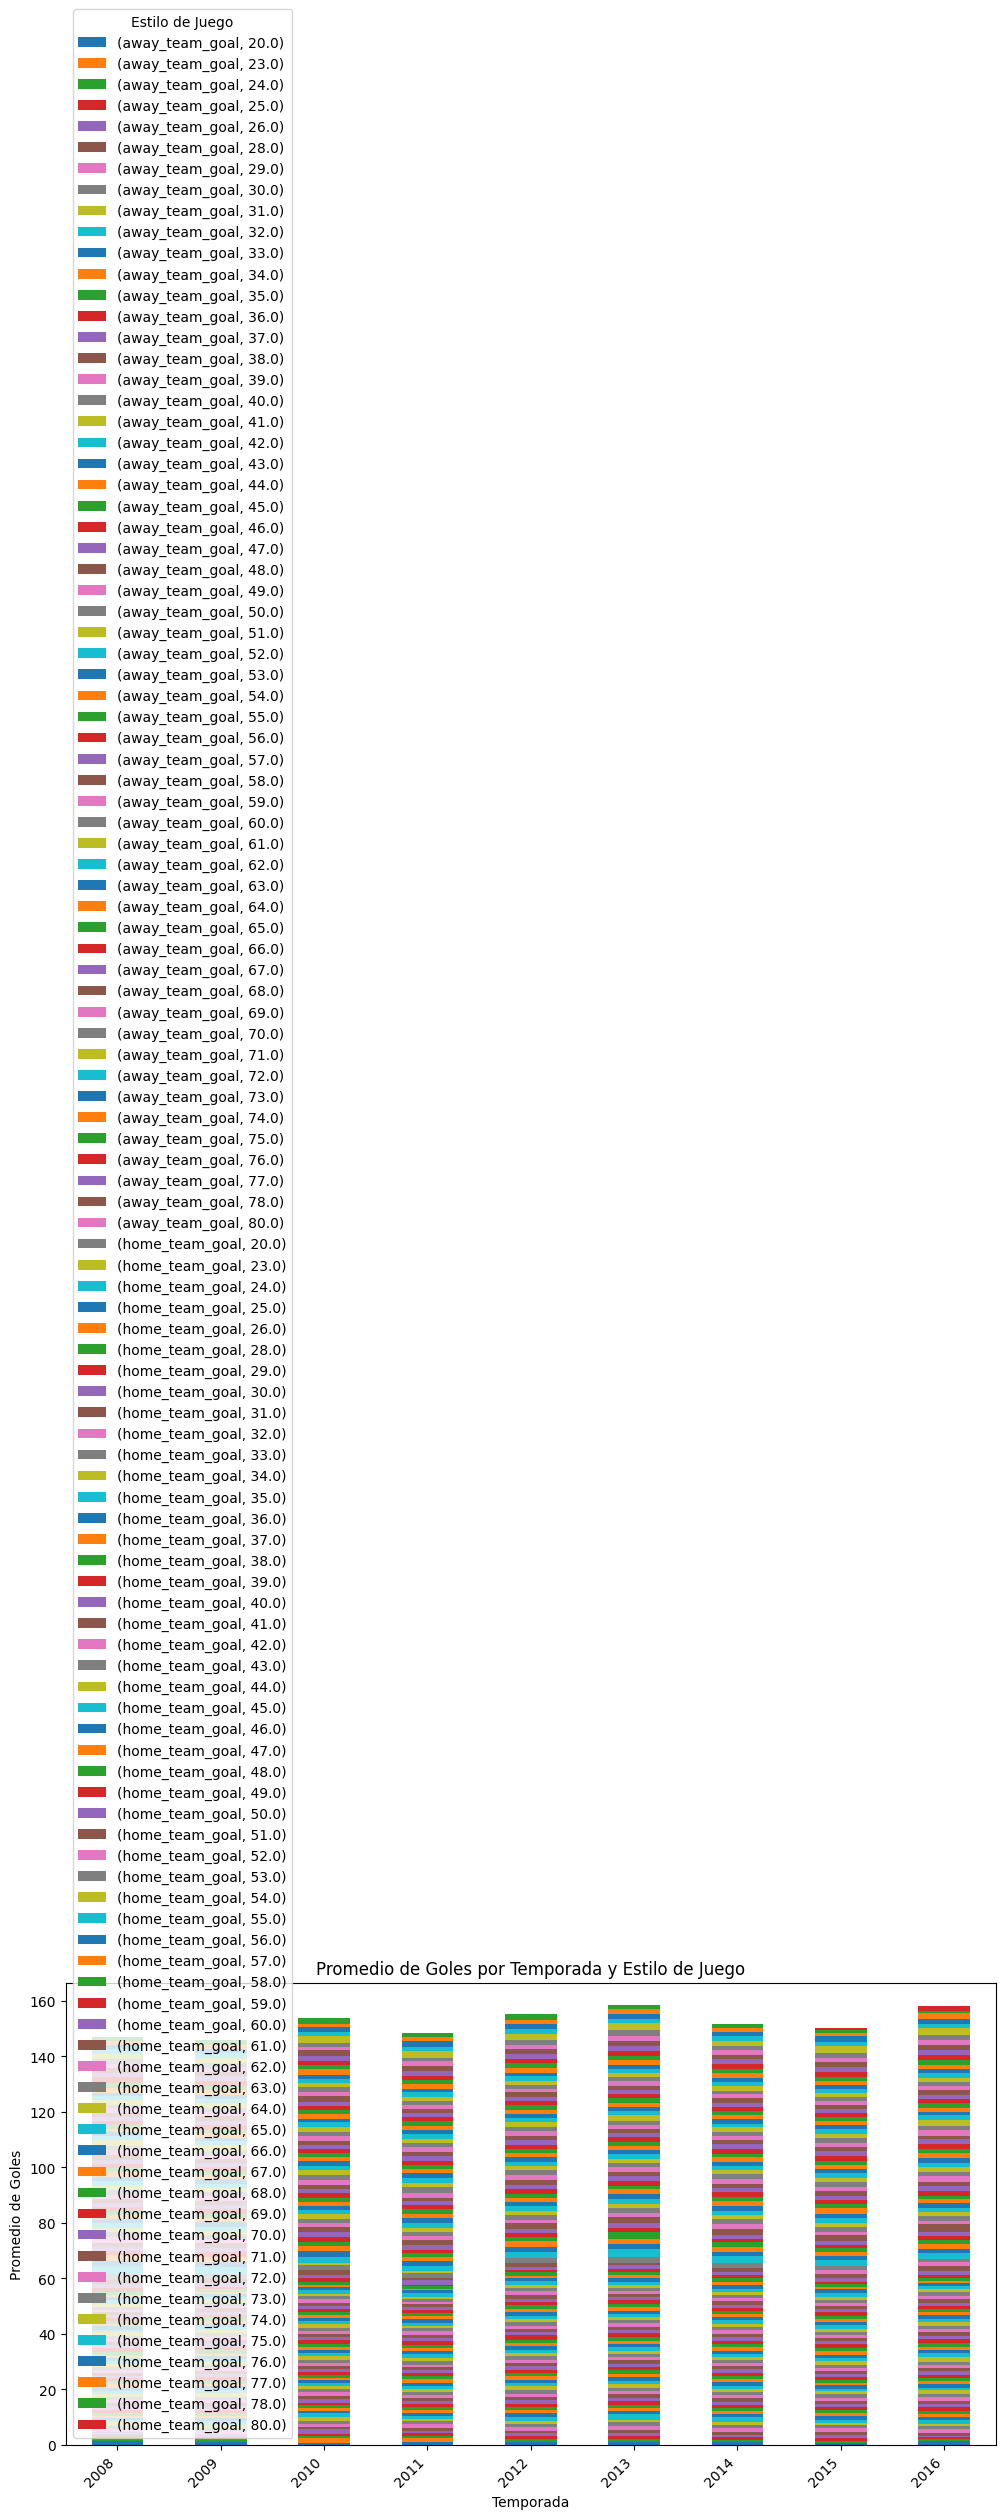

In [11]:
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Promedio de Goles por Temporada y Estilo de Juego')
plt.xlabel('Temporada')
plt.ylabel('Promedio de Goles')
plt.legend(title='Estilo de Juego')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Pregunta de Negocio:

¿Cómo puede el análisis de los estilos de juego ayudar a los equipos a decidir cómo enfrentar a sus oponentes en futuras temporadas? ¿Deberían cambiar su estilo de juego según los rivales?

##Parte 5: Conclusión y Storytelling (20 Puntos)
5.1 Storytelling Basado en los Insights

Obtenidos (10 Puntos)
Con base en todos los análisis anteriores, redacta una narrativa que explique los insights obtenidos. Asegúrate de incluir cómo la tendencia de los goles y el estilo de juego de los equipos ha evolucionado con el tiempo.

Puntos a incluir en el Storytelling:

¿Qué equipos han sido los más dominantes en las últimas temporadas y por qué?
¿Cómo han cambiado los estilos de juego y cómo eso ha influido en los resultados?
¿Qué tipo de ajustes tácticos pueden hacer los equipos según los resultados de este análisis?


5.2 Conclusión y Recomendaciones Finales (10 Puntos)
Proporciona una conclusión basada en el análisis y da recomendaciones prácticas para los equipos. Considera cómo los datos analizados pueden ayudar en la toma de decisiones estratégicas, como la compra de jugadores, tácticas de juego, y preparación para futuras temporadas.